<a href="https://colab.research.google.com/github/shriver42/ESAA/blob/%ED%95%84%EC%82%AC-%EA%B3%BC%EC%A0%9C/0902_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. 분류
##3.1 MNIST




In [47]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [48]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [49]:
y.shape

(70000,)

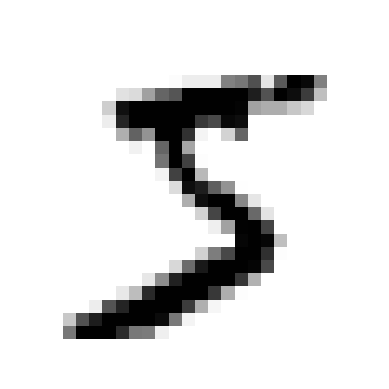

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [51]:
#레이블은 문자열
y[0]

'5'

In [52]:
import numpy as np
y = y.astype(np.uint8)

In [53]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##3.2 이진 분류기 훈련


In [54]:
y_train_5 = (y_train == 5)   #5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

확률적 경사 하강법(SGD)를 이용하면 큰 데이터셋을 효율적으로 처리할 수 있다

In [55]:
from sklearn.linear_model import SGDClassifier

#SGDClassifier은 무작위 훈련을 하기에, 결과 재현을 위해서는 ranodm_state을 넣어주어야 한다
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [56]:
sgd_clf.predict([some_digit])

array([ True])

##3.3 성능 측정
###3.3.1 교차 검증을 사용한 정확도 측정

In [57]:
#cross_val_score() 함수와 거의 동일한 결과를 출력함
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [58]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring= 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [59]:
#'5아님' 클래스로 분류하는 더미 분류기 생성
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X,y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype = bool)

In [60]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

이미지의 10%정도만 숫자 5이기 때문에 무조건 '5아님'예측은 90% 정도 맞는다</br>
불균형한 데이터셋을 다룰때 정확도를 성능 지표로 사용하지 않는 이유를 보여줌

###3.3.2 오차행렬
클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것</br>
숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면, 오차행렬의 5행 3열을 보면 된다

In [61]:
#실제 타깃과 비교할 예측값을 만든다
#test set은 최종 마지막에 사용해야 하기에 쓸 수 없다
#cross_val_predict은 평가 점수 대신 각 테스트 폴드의 예측값을 반환한다
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [63]:
y_train_perfect_predictions = y_train_5   #완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

###3.3.3 정밀도와 재현율

정밀도 = TP / (TP + FP) </br>
정밀도 : 양성 예측의 정확도 </br>
재현율 = TP / (TP + FN)  </br>
재현율 : 분류기가 정확하게 감지한 양성 샘플의 비율

In [64]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [65]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F점수 : 정밀도와 재현율의 조화 평균</br>
정밀도와 재현율이 비슷한 분류기에서는 f1 점수가 높지만 이게 항상 바람직하지는 X

In [66]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

###3.3.4 정밀도/재현율 트레이드오프

In [67]:
#임곗값 직접 지정은 불가하지만, 예측에 사용한 점수는 확인 가능함
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [68]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [69]:
#위보다 임곗값을 높여보자
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [70]:
#적절한 임곗값 설정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [71]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

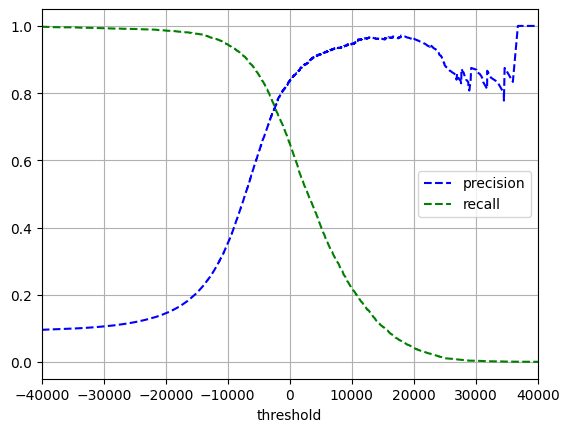

In [72]:
def plot_precision_recvall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
  plt.plot(thresholds, recalls[:-1], 'g--', label='recall')
  plt.grid()
  plt.xlim(-40000,40000)
  plt.legend()
  plt.xlabel('threshold')


plot_precision_recvall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [73]:
#정밀도가 90%가 되는 가장 낮은 임곗값 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [74]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [75]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [76]:
recall_score(y_train_5, y_train_pred_90)

0.47980077476480354

###3.3.5 ROC 곡선
거짓 양성비율(FPR)과 진짜 양성비율(TPR)의 곡선이다.

In [77]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

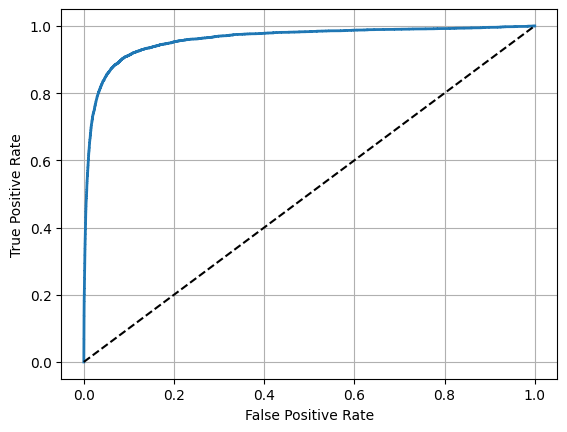

In [78]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1], [0,1], 'k--')   #대각 점선
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid()

plot_roc_curve(fpr,tpr)
plt.show()

TPR(재현율)과 거짓양성(FPR)은 트레이트 오프이다.</br>
점선은 완전한 랜덤 분류기의 ROC 곡선을 의미하며 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다.

AUC을 측정하면 분류기들을 비교할 수 있다.</br>
완벽한 분류기는 ROC의 AUC가 1이며 완전한 랜점 분류기는 0.5이다.

In [79]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하며, 그렇지 않으면 ROC 곡선을 사용한다.

In [80]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

In [81]:
y_scores_forest = y_probas_forest[:,1]    #양성 클래스에 대한 확률을 점수로 사용한다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

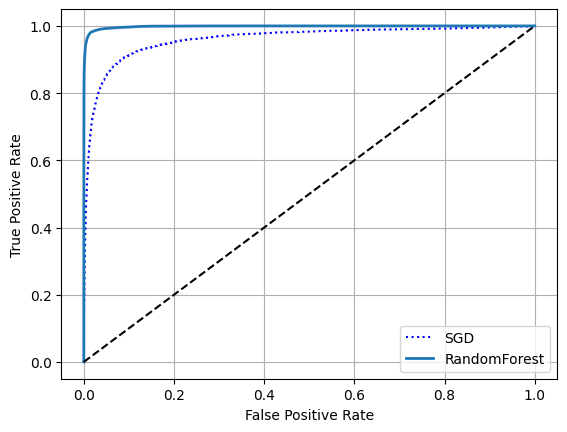

In [82]:
plt.plot(fpr,tpr,'b:',label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc = 'lower right')
plt.show()

In [83]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

##3.4 다중 분류
OvR : 이미지를 분류할 때 각 분류기의 점수 중에 가장 높은 것을 클래스로 선택하면 된다</br>
OvO : 각 숫자 조합마다 이진 분류기를 훈련시킨다

In [84]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train[:2000], y_train[:2000])   #y_train_5 가 아닌 y_train을 사용한다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [85]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [86]:
np.argmax(some_digit_scores)

5

In [87]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [88]:
svm_clf.classes_[5]

5

In [89]:
#사이킷런에서 OvO나 OvR을 강제시키기 위해서
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [90]:
len(ovr_clf.estimators_)

10

In [91]:
#SGDClassifier 훈련시키기
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [92]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [93]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [94]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

##3.5 에러분석

In [95]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

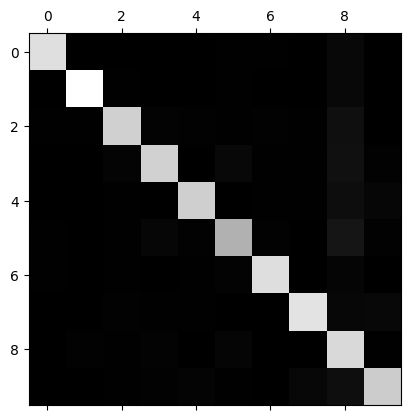

In [96]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [97]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

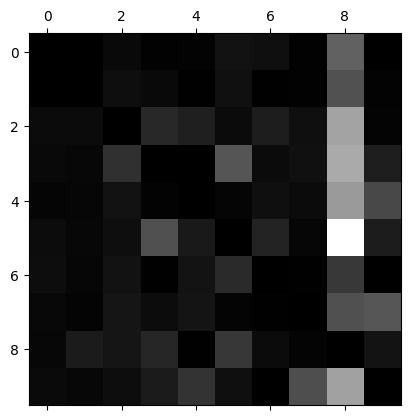

In [98]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

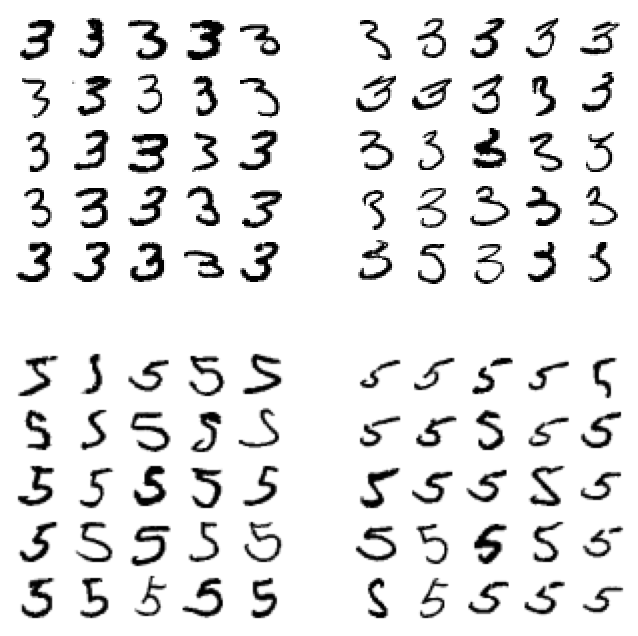

In [99]:
cl_a, cl_b=3, 5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

##3.6 다중 레이블 분류
분류기가 샘플마다 여러 개의 클래스를 출력해야 할때. 즉, 여러 개의 이진 꼬리표 출력 분류 시스템

In [100]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [101]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [102]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

위의 코드는 모든 레이블의 가중치가 같다고 가정하고 진행한 것

##3.7 다중 출력 분류
한 레이블이 다중 클래스가 될 수 있도록 일반화한 것. 즉, 값을 두 개 이상 가질 수 있다

In [103]:
noise=np.random.randint(0, 100, (len(X_train), 784))
X_train_mod=X_train+noise
noise=np.random.randint(0, 100, (len(X_test), 784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

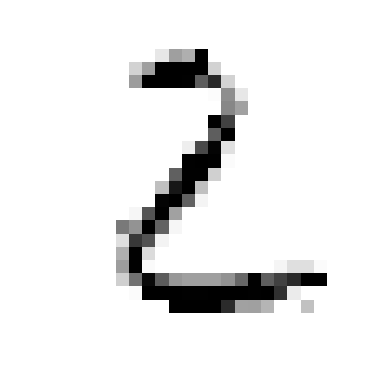

In [104]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[1]])
plot_digits(clean_digit)